In [1]:
# Data wrangling
import numpy as np
import pandas as pd

# DataViz
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from dython.nominal import associations
from scipy.stats import f_oneway, ttest_ind

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Seaborn settings
sns.set_theme(
    context="notebook",
    style="ticks",
    palette="colorblind",
    font_scale=.8, 
    rc = {
        "axes.grid": True,
        "grid.alpha": .2,
        "axes.titlesize": "x-large",
        "axes.titleweight": "bold",
        "axes.titlepad": 20
    }
)

<h1> Churn Prediction Notebook - CRISP-DM</h1>

This notebook aims to show CRISP-DM process in a churn prediction case with its steps and its inputs and outputs.

# 1 - Business Understanding

## 1.1 - Churn Prediction

Churn prediction is related to detection of which customers tend to cancel a service. Companies spend money to acquire new clients, so clients losses represent investment lost. Retaining clients can be less expensive that acquiring new clients.

**Source**: https://www.avaus.com/blog/predicting-customer-churn/#:~:text=Churn%20prediction%20means%20detecting%20which,more%20than%20retaining%20existing%20ones

## 1.2 - Objectives
In addiction to accuracy, another metrics must be analyzed. It is important to predict churn, but expending money to retain a client that aren't churn must be avoided. Therefore, in addition to accuracy the following metrics with its respectives lower limits will be considered:

# 2 - Data Understanding

## 2.1 - Data Loading

In [3]:
df = pd.read_excel("churn_data.xlsx")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2.2 - Initial Exploration

In [4]:
# Showing DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


The dataset hasn't NaN data

We have decreased the DataFrame size by changing object to category.

In [5]:
# Showing DataFrame statistics
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [6]:
# Feature SeniorCitizen clearly must be treated as categorical
print(df["SeniorCitizen"].unique())

# Before outliers analysis, converting SeniorCitizen to category data type
df["SeniorCitizen"] = df["SeniorCitizen"].astype("category")

# Selecting numerical and categorical columns after converting SeniorCitizen
num_cols = df.select_dtypes("number").columns
cat_cols = (
                df.select_dtypes(exclude="number")
                .columns.drop(labels=["customerID", "Churn"])
            )

# Converting categorical features into category
df[cat_cols] = df[cat_cols].astype("category")

[0 1]


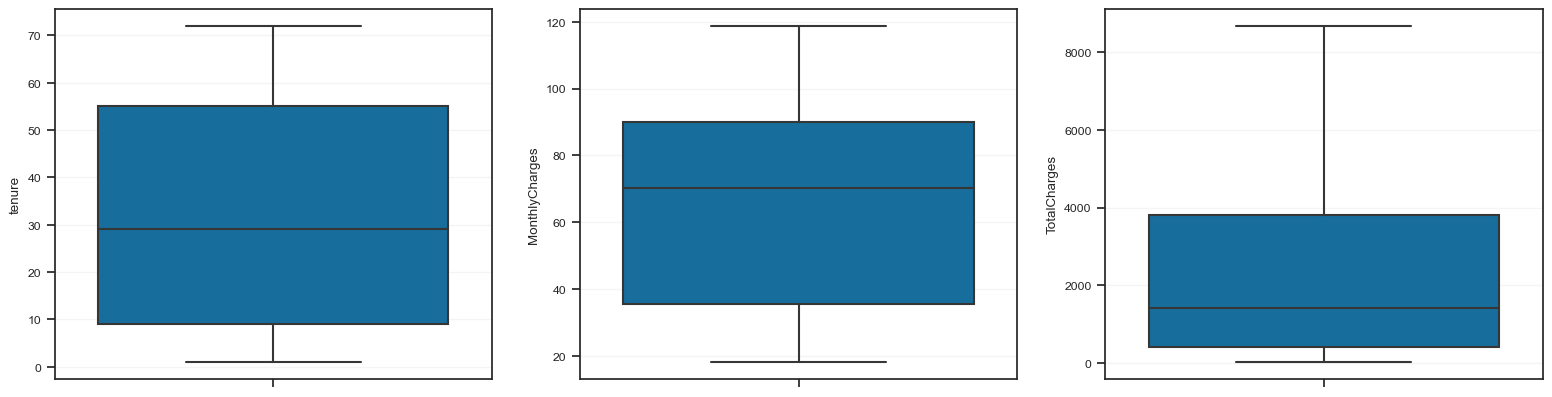

In [7]:
# Plotting boxplot for outliers detection and distribution analysis
fig, axes = plt.subplots(ncols=3, figsize=(6.4*3, 4.8))
for ax, col in zip(axes, num_cols):
    sns.boxplot(data=df, y=col, ax=ax, showfliers=True)

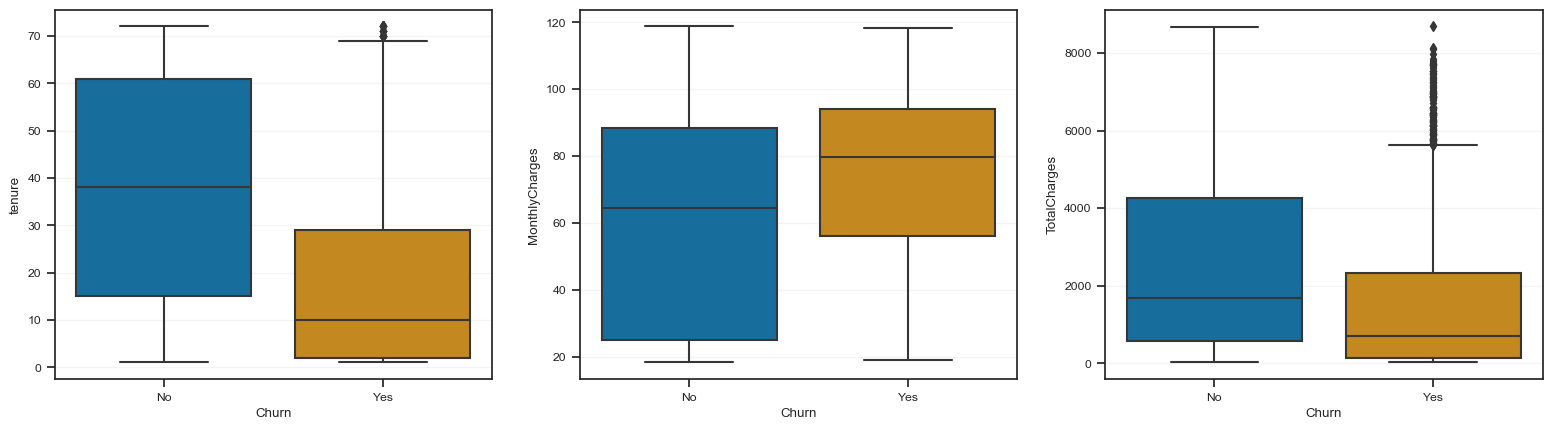

In [8]:
# Plotting boxplot for outliers detection and distribution analysis by churn target
fig, axes = plt.subplots(ncols=3, figsize=(6.4*3, 4.8))
for ax, col in zip(axes, num_cols):
    sns.boxplot(data=df, y=col, x="Churn", ax=ax, showfliers=True)

## 2.3 - Initial Exploration Report

- There isn't NaN values;
- There isn't outliers following IQR method when analysing all rows of numerical features;
- When splitting numerical features by target feature, we have outliers in "yes" category;
- Numerical features must be standardized;
- Categorical features must be encoded for training models;
- There are only three numerical features: Tenure, MonthlyCharges and TotalCharges.

# 3 - Data Preparation

According to Initial Exploration Report isn't necessary to deal with NaN values. The creation of new values will be considered according to Models Evaluation Report.

## 3.1 - Association

To test the association between categorical features we will use Cramer's V and Theil's U tests with Dython Library. Explanations off these tests and Dython can be read in following articles:  
  
**The Search for Categorical Correlation**: <url>https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9</url>  
**Generate Numerical Correlation and Nominal Association Plots using Python**: <url>https://onezero.blog/generate-numerical-correlation-and-nominal-association-plots-using-python/</url>


### 3.1.1 - Categorical x Categorical association

To analyse and compute association between categorical features we will use data visualization and the tests Cramers'V and Theils'U.
Cramers'V and Theils'U are computed via dython library>

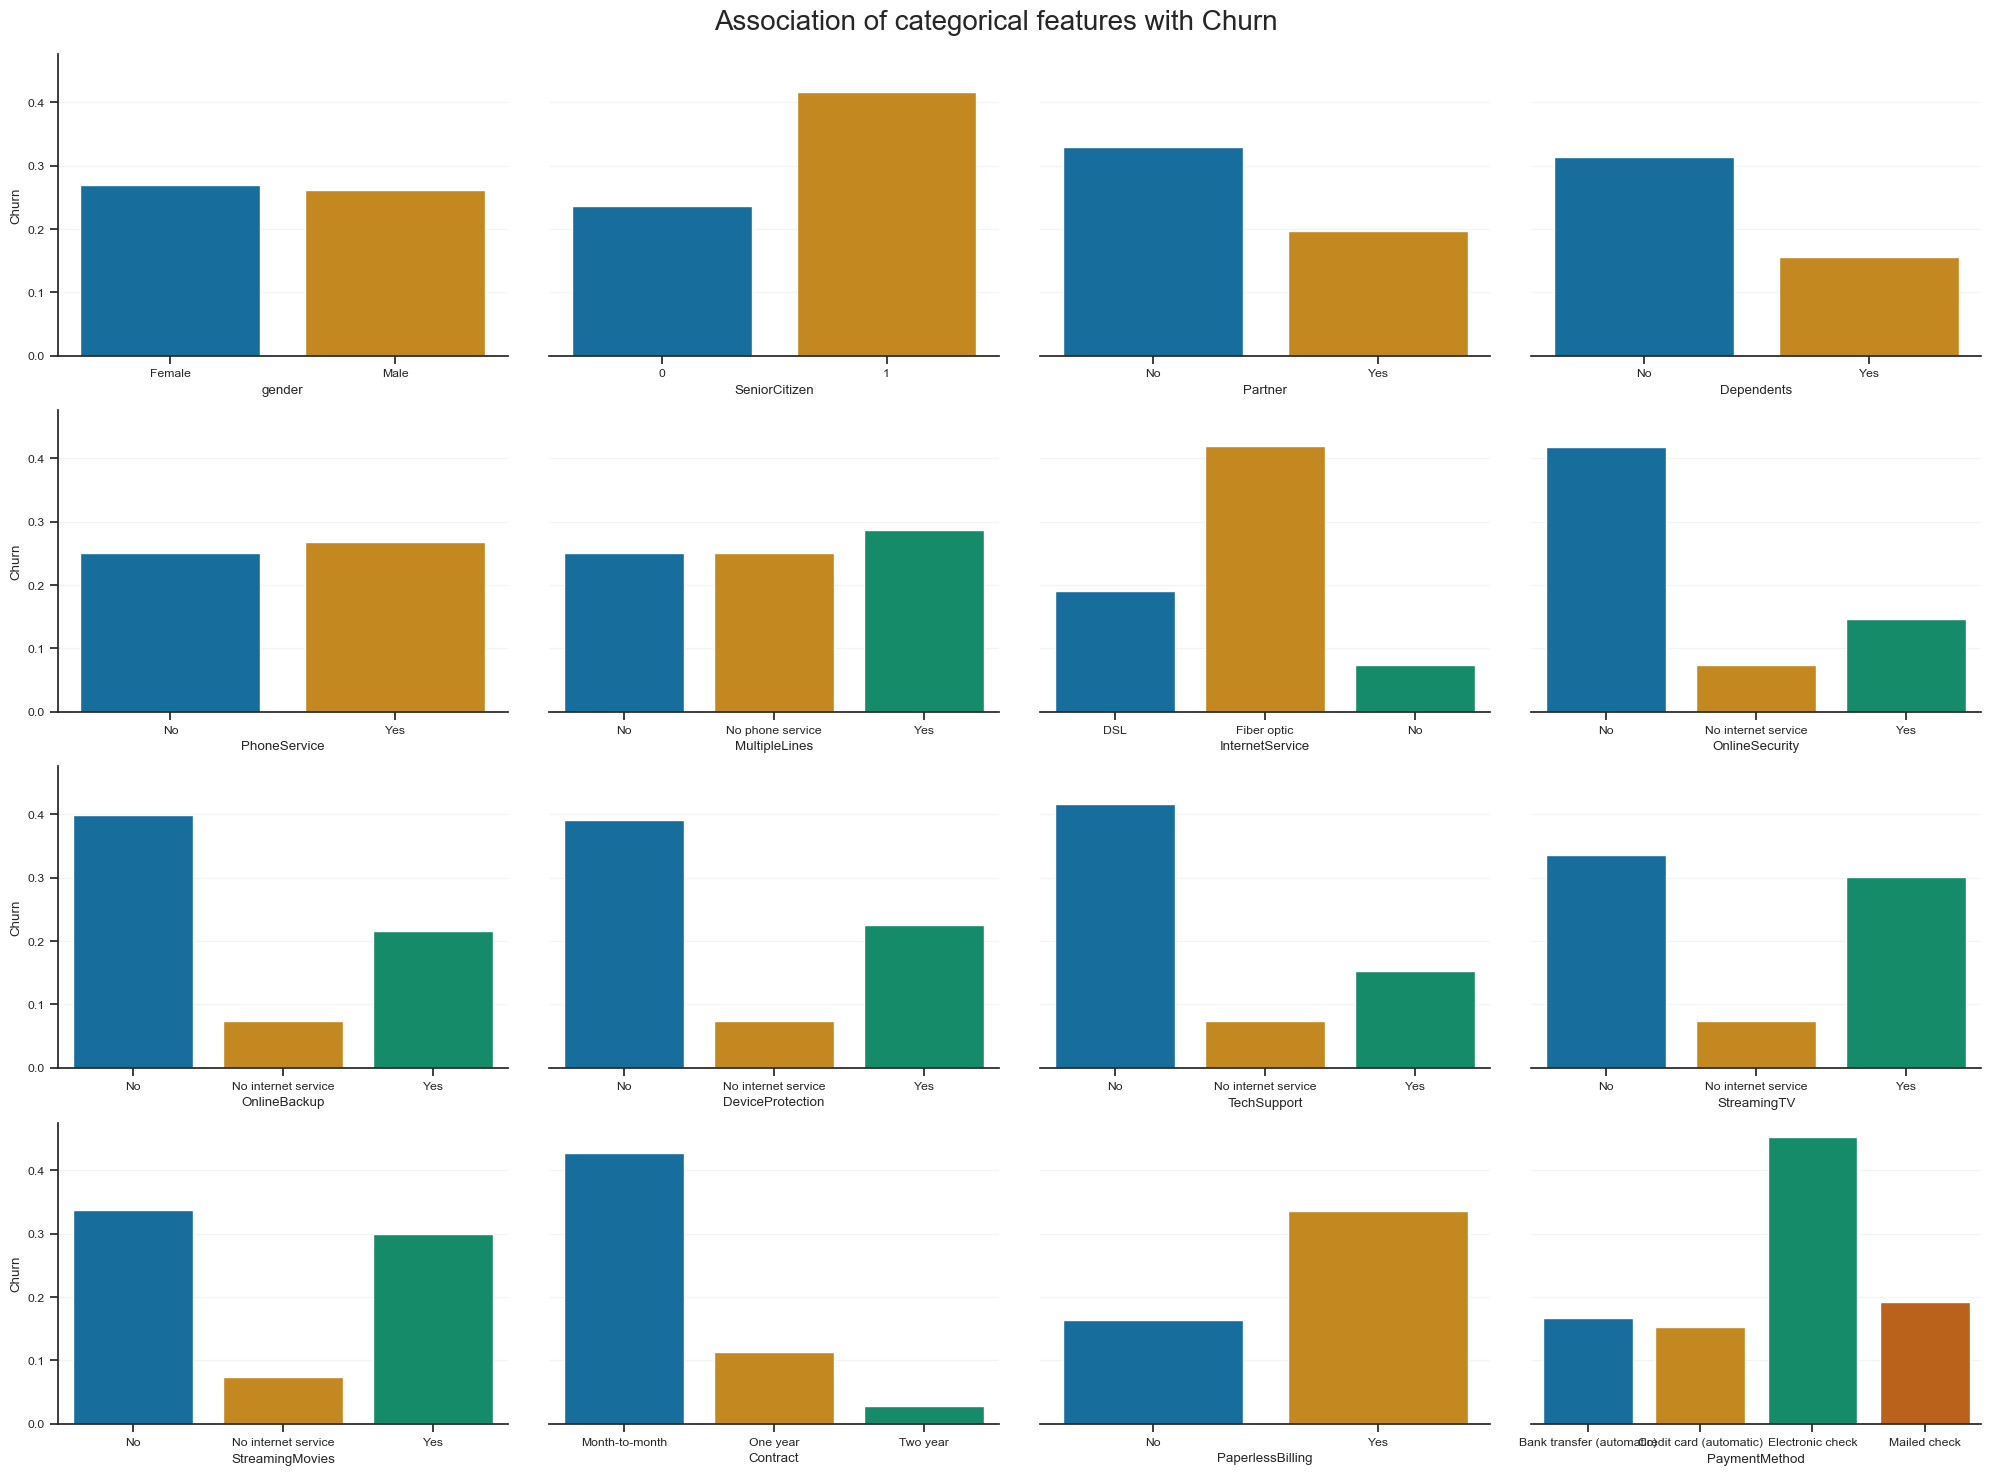

In [9]:
# Visualizing influence of categories on Churn via barplot
ncols = 4
nrows = np.ceil(len(cat_cols) / ncols).astype(int)
fig, axes = plt.subplots(figsize=(20, 15), nrows=nrows, ncols=ncols, sharey=True)
axes = axes.flatten()
for i, col in enumerate(cat_cols):
    sns.barplot(data=df, x=col, y=df["Churn"].map({"No": 0, "Yes": 1}).astype("int64"),
                ax=axes[i], errorbar=None)
    axes[i].set_ylabel("")
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)
    if i % ncols == 0:
        axes[i].set_ylabel("Churn")
    else:
        axes[i].spines["left"].set_visible(False)
        axes[i].tick_params(axis="y", which="both", left=False)

for ax in axes[len(cat_cols):]:
    ax.set_axis_off()
    
fig.suptitle(f"Association of categorical features with Churn", size=20)
fig.tight_layout()
fig.subplots_adjust(top=.95)

In graphic above, the categories that seems to be more associeated with Churn are:
- InternetService;
- OnlineSecurity;
- TechSupport;
- Contract;
- PaymentMethod.

For categorical x categorical analysis, Cramer's V and Theil's U tests will be used. These tests are better explained in following links:  
 <url>https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9</url>  
 <url>https://onezero.blog/generate-numerical-correlation-and-nominal-association-plots-using-python/</url>

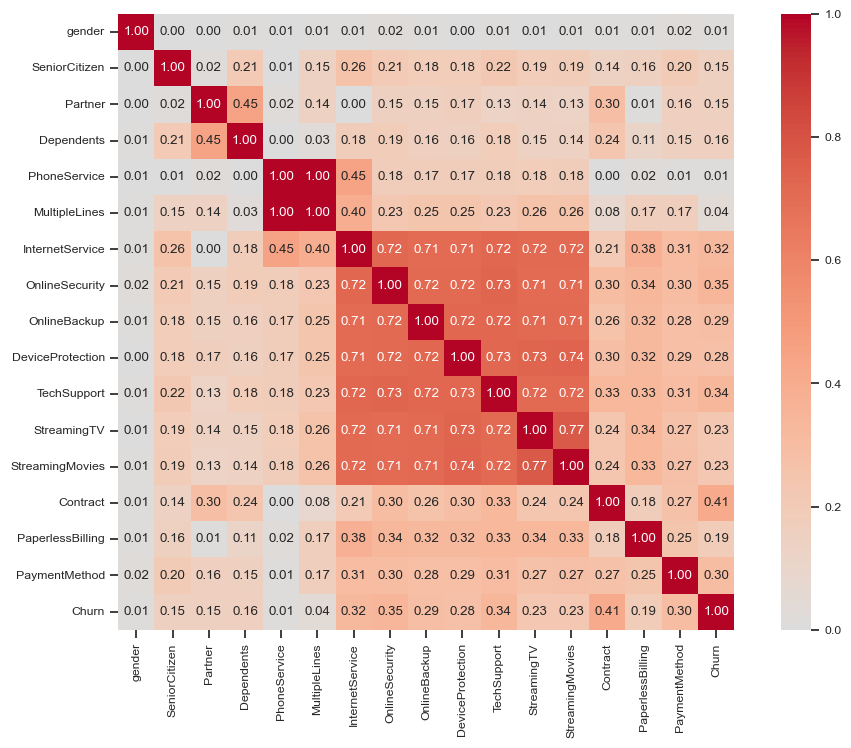

In [10]:
# Cramers's V heatmap
fig, ax = plt.subplots(figsize=(12, 8))
cramers_v = associations(pd.concat([df[cat_cols], df["Churn"].astype("category")], axis=1),
                         nom_nom_assoc="cramer",
                         ax=ax,
                         cramers_v_bias_correction=False,
                         cmap="coolwarm"
                        )

In graphic above, the categories that seems to be more associeated with Churn are:
- Contract;
- OnlineSecurity;
- TechSupport;
- InternetService;
- PaymentMethod.

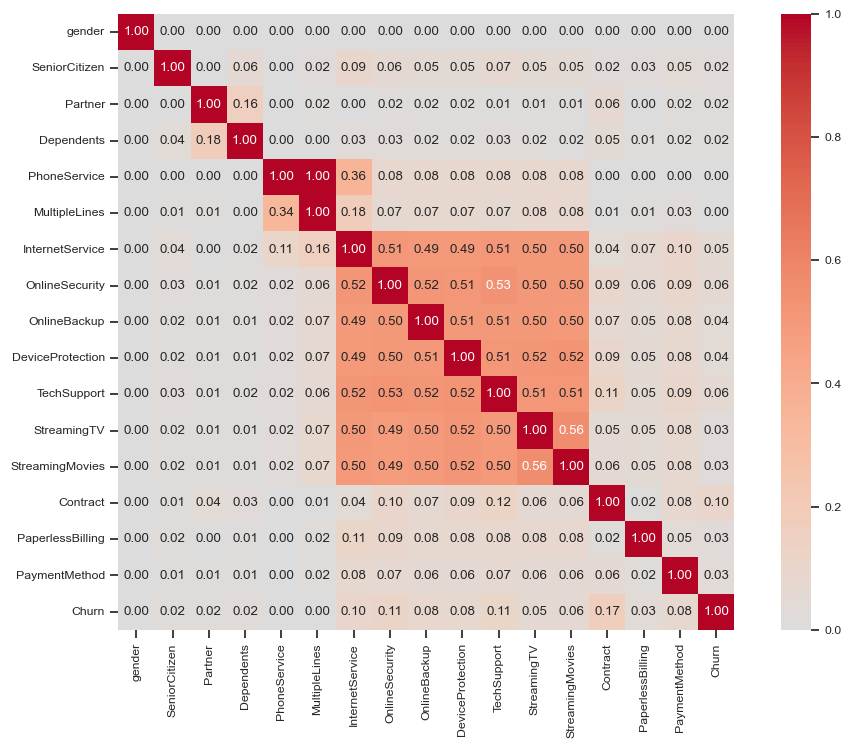

In [11]:
# Theil's U heatmap
fig, ax = plt.subplots(figsize=(12, 8))
cramers_v = associations(pd.concat([df[cat_cols], df["Churn"].astype("category")], axis=1),
                         nom_nom_assoc="theil",
                         ax=ax,
                         cmap="coolwarm"
                        )

We have significant association between the following features according to Cramer's V and Theil's U test,:
- InternetService;
- OnlineSecurity;
- OnlineBackup;
- DeviceProtection;
- TechSupport;
- StreamingTv;
- StreamingMovies.

We can test model only with TechSupport for study purposes. 

In [12]:
# Categorical cols to drop
cat_cols2drop = ["InternetService",
                 "OnlineSecurity",
                 "OnlineBackup",
                 "DeviceProtection",
                 "StreamingTv",
                 "StreamingMovies"]

### 3.1.2 - Numerical x Categorical Association

To verify association between numerical and categorical variables, ANOVA (analysis of variance) and t-test will be used. For more details, I recommend the following link:  
<url>http://www.sefidian.com/2020/08/02/measure-the-correlation-between-numerical-and-categorical-variables-and-the-correlation-between-two-categorical-variables-in-python-chi-square-and-anova/</url>

Before implementing ANOVA and T-test, we will see how numerical features are distributed by categories.

In [13]:
round((len(cat_cols) + 1) / ncols +.5) 

5

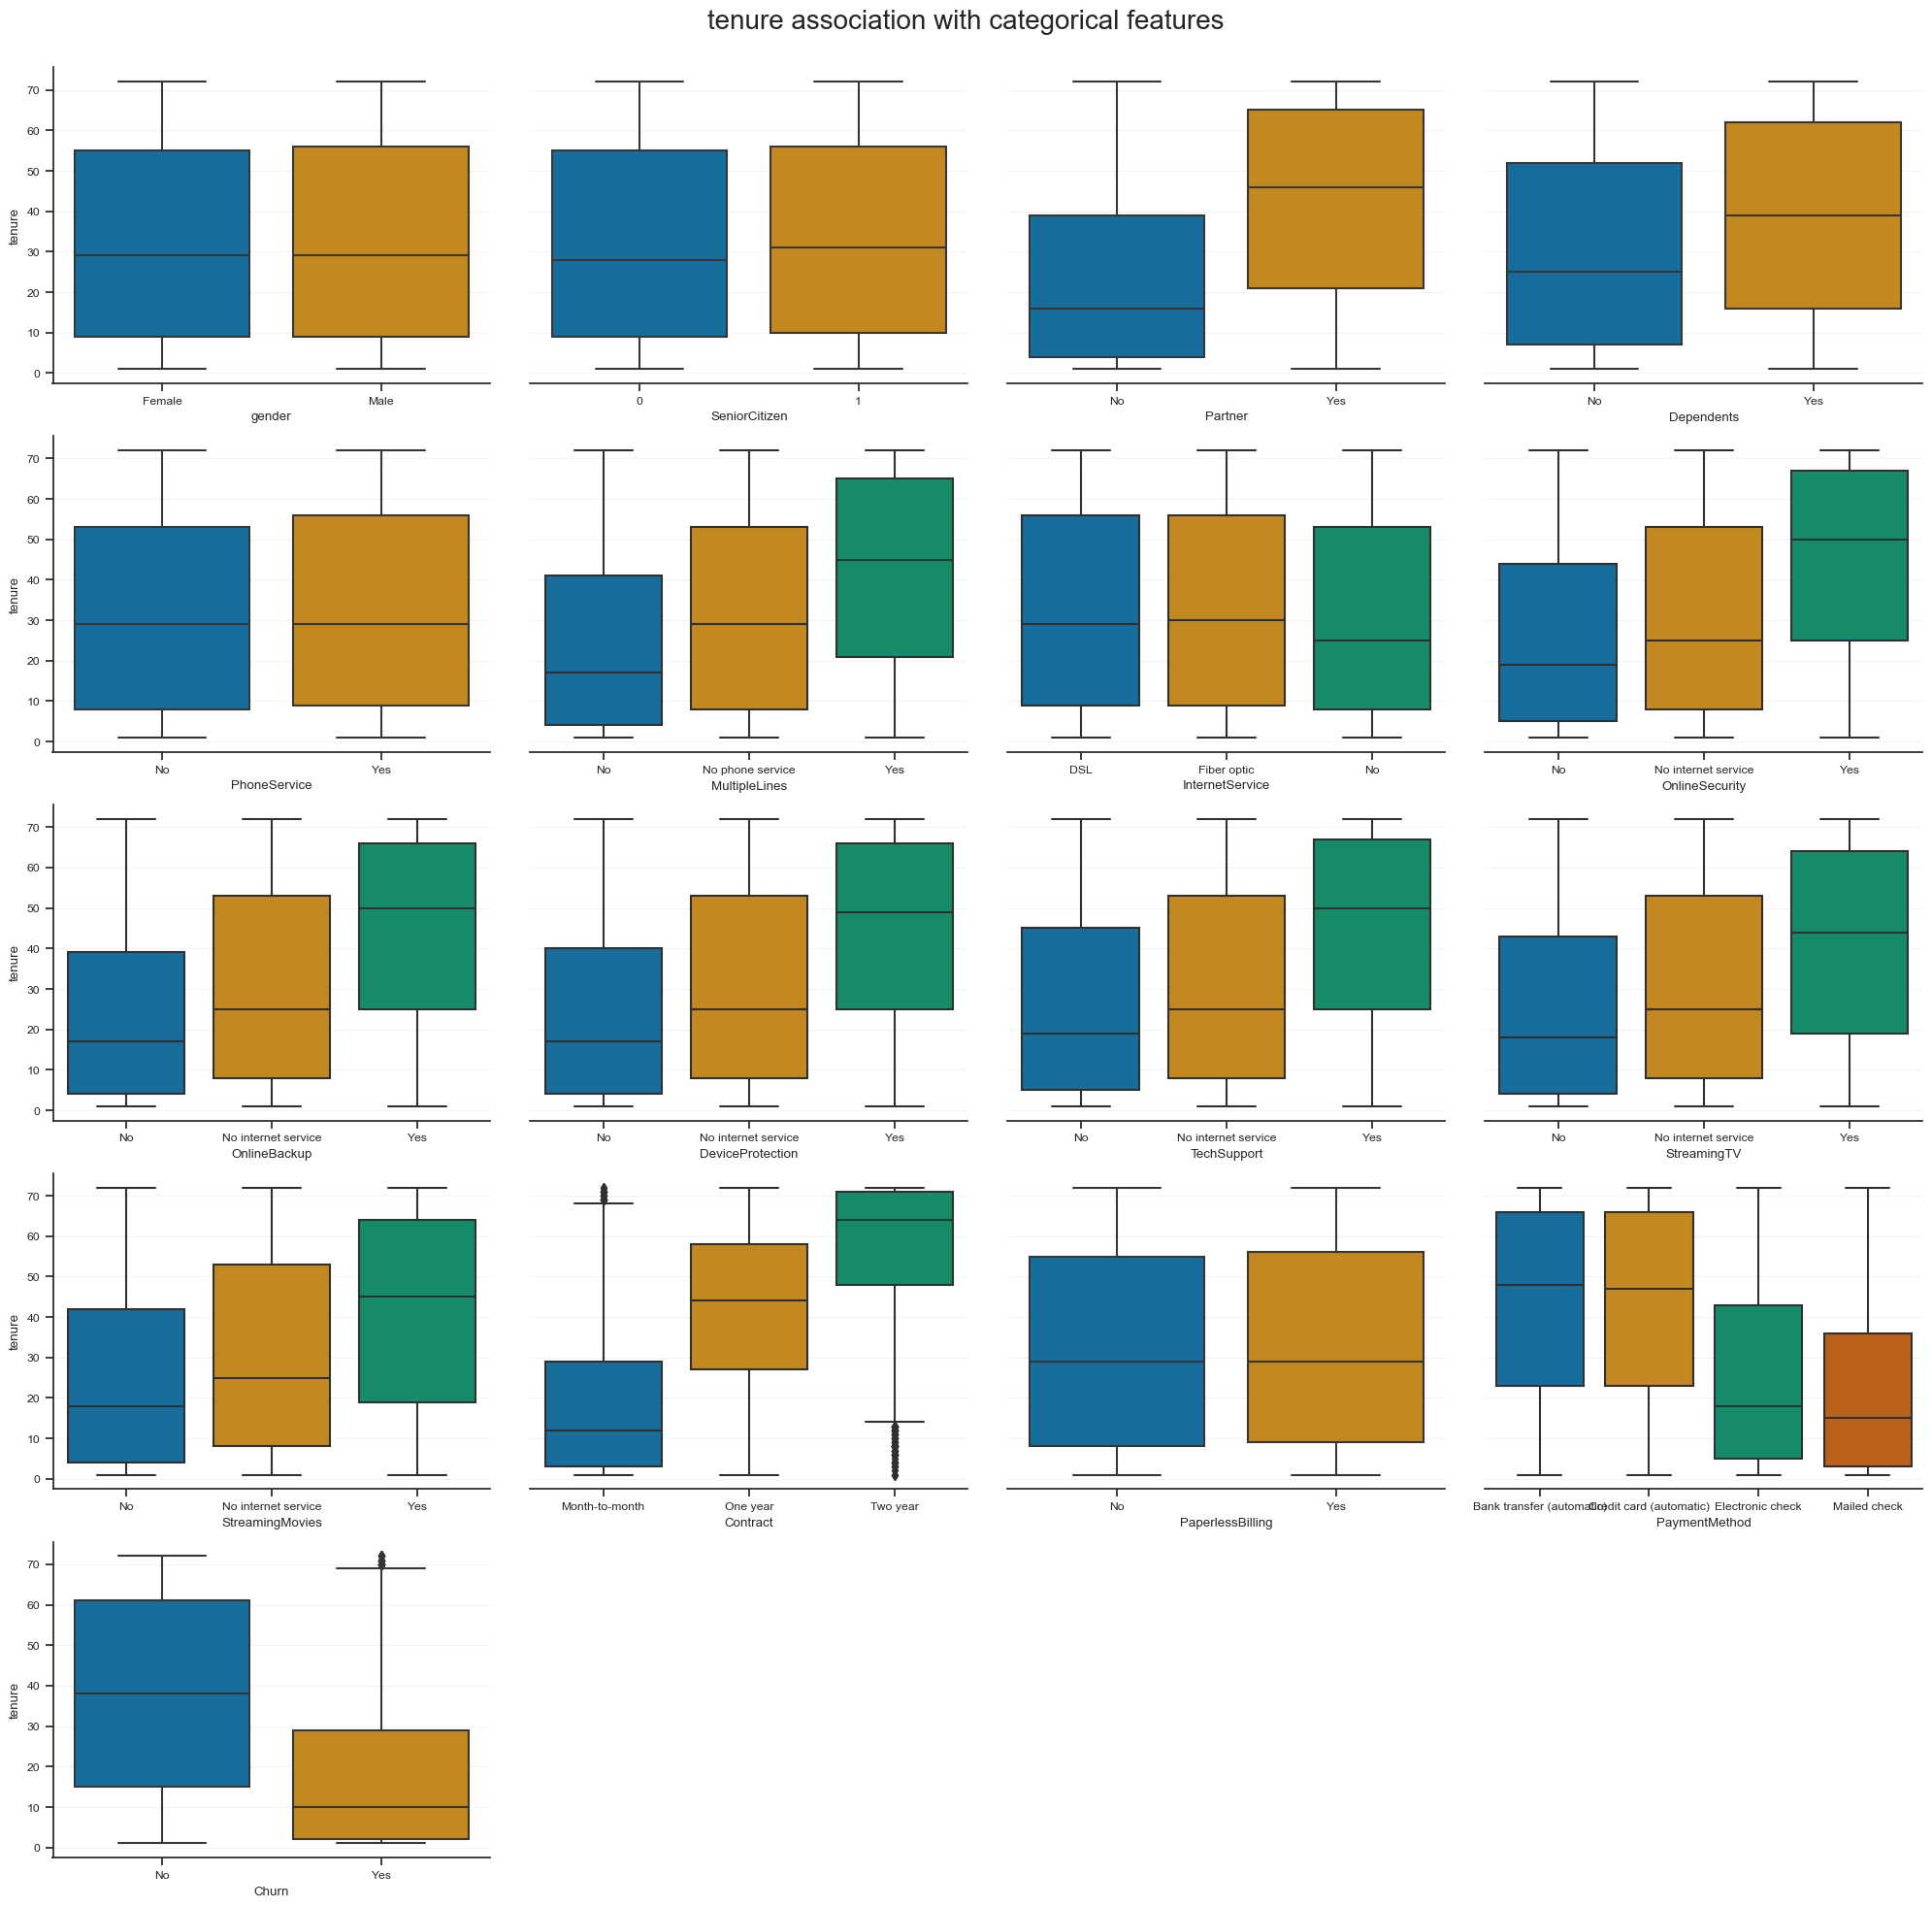

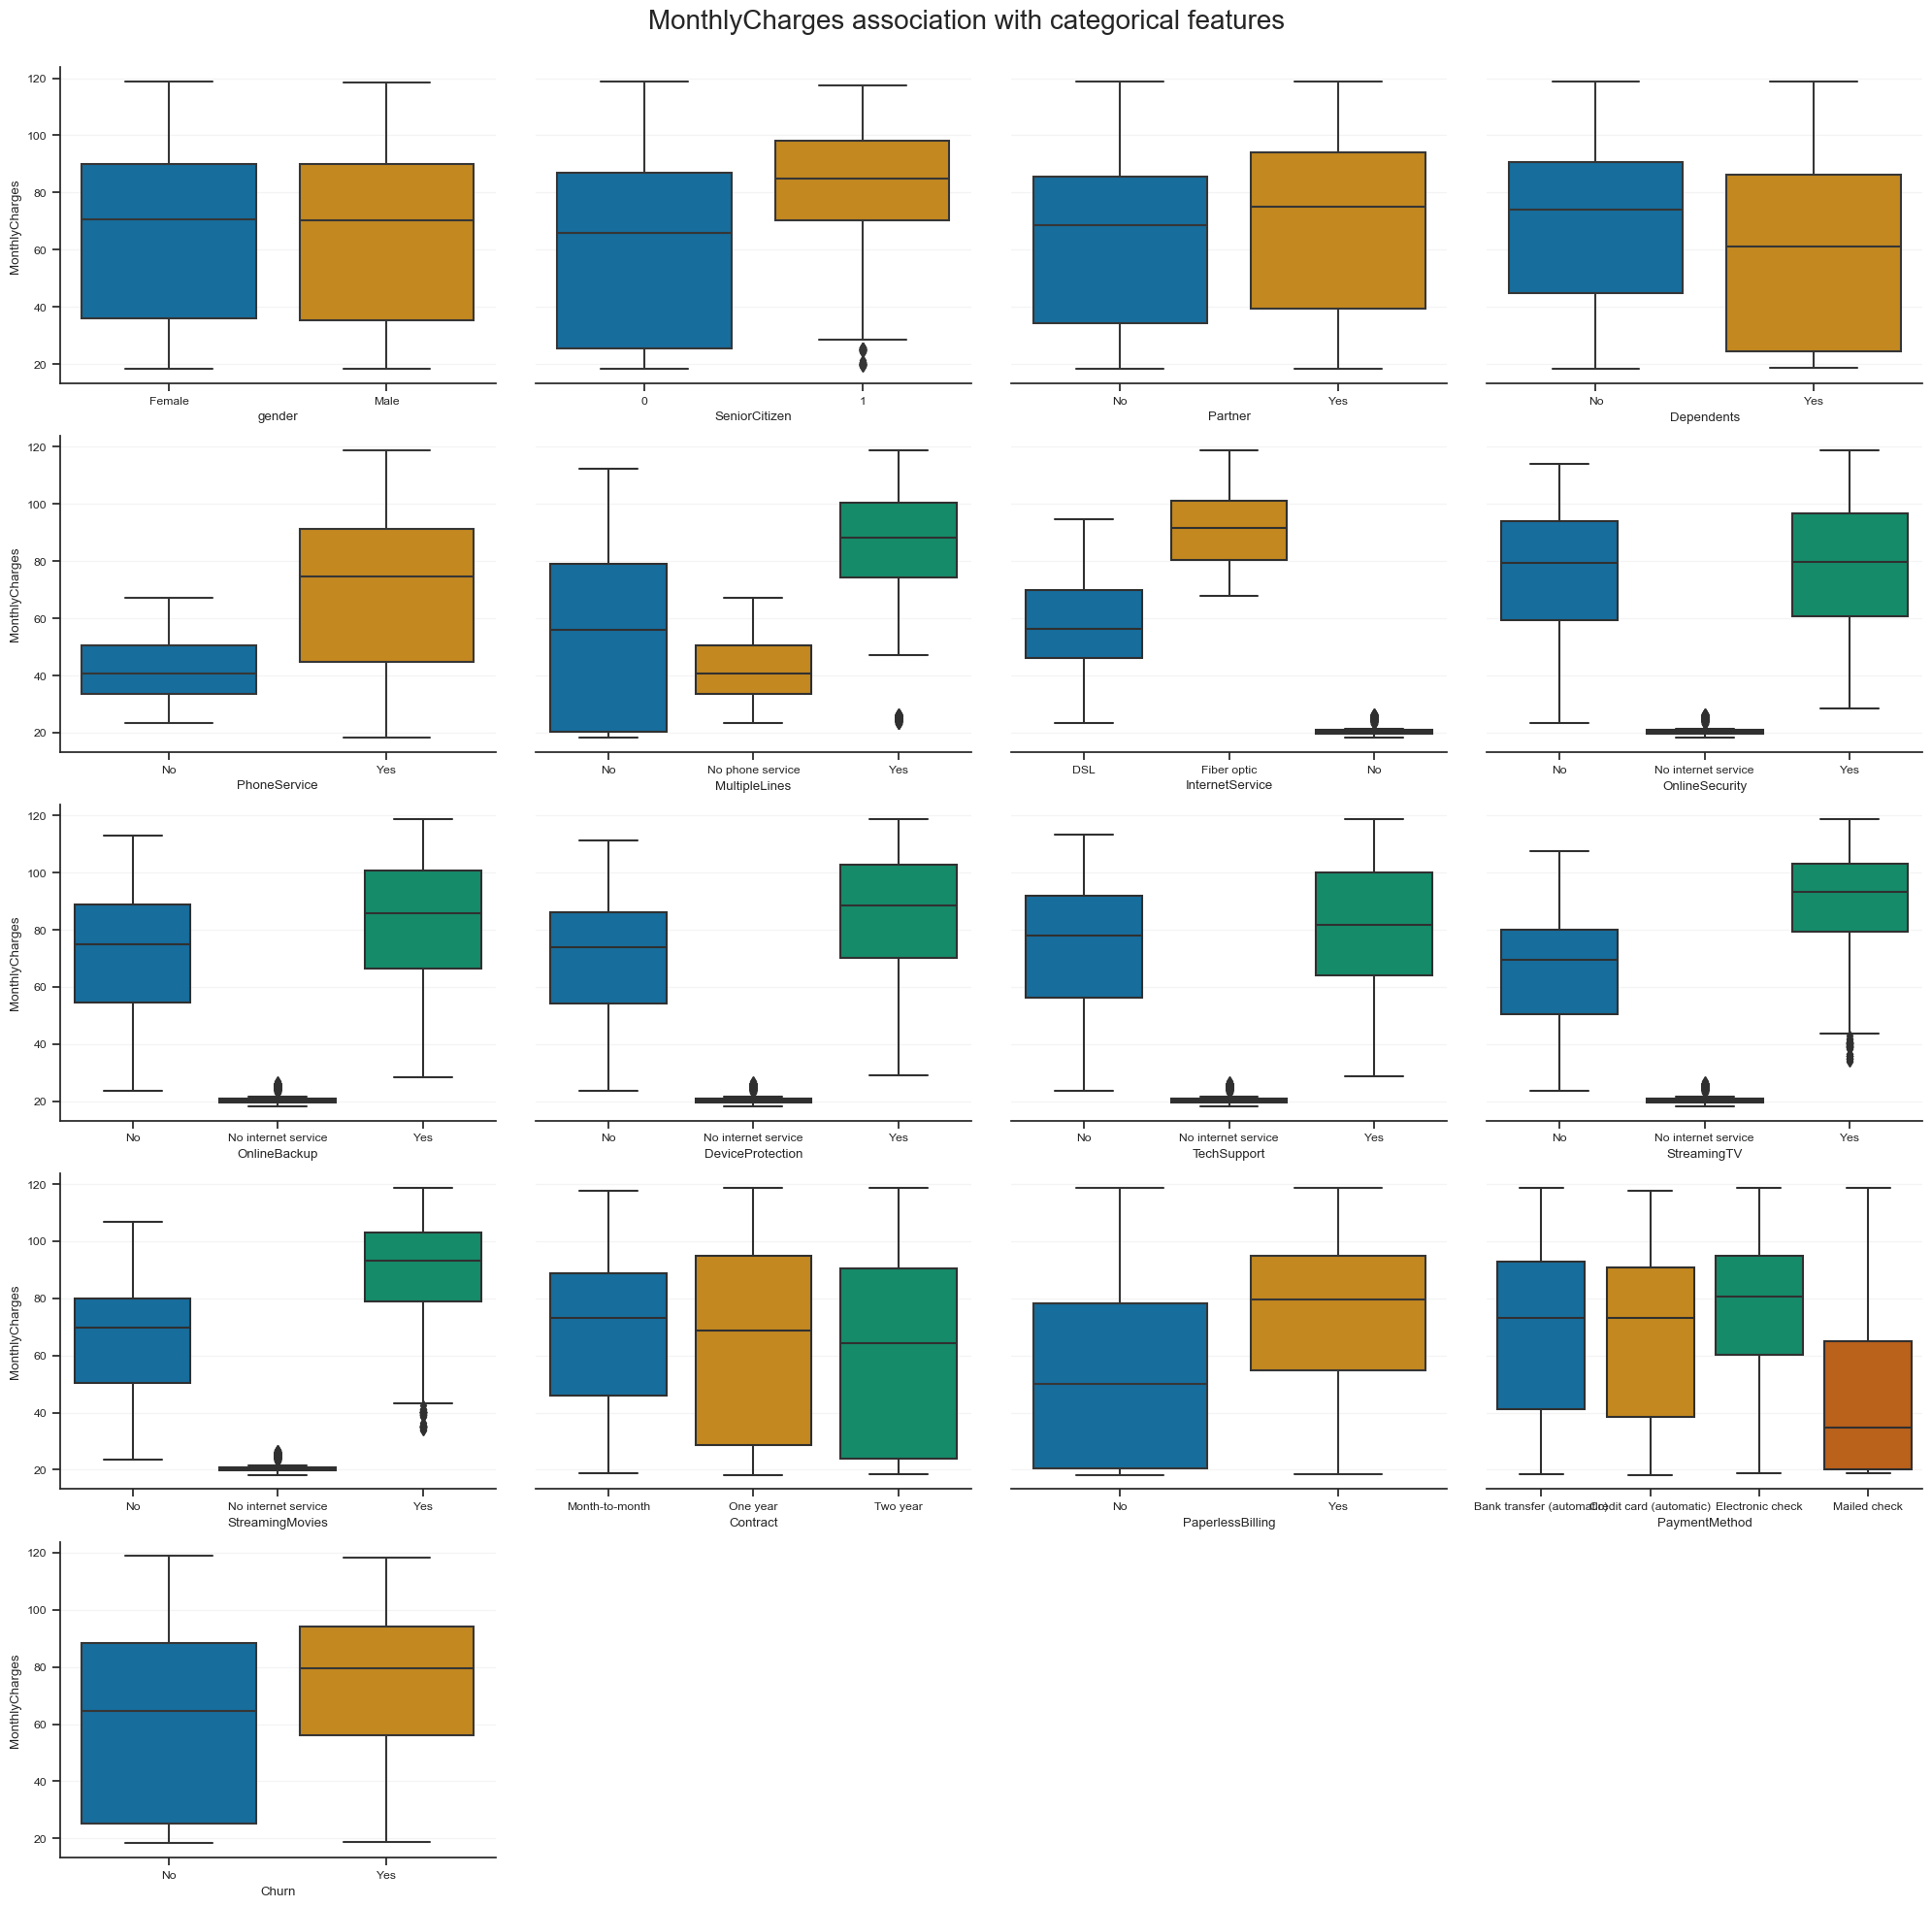

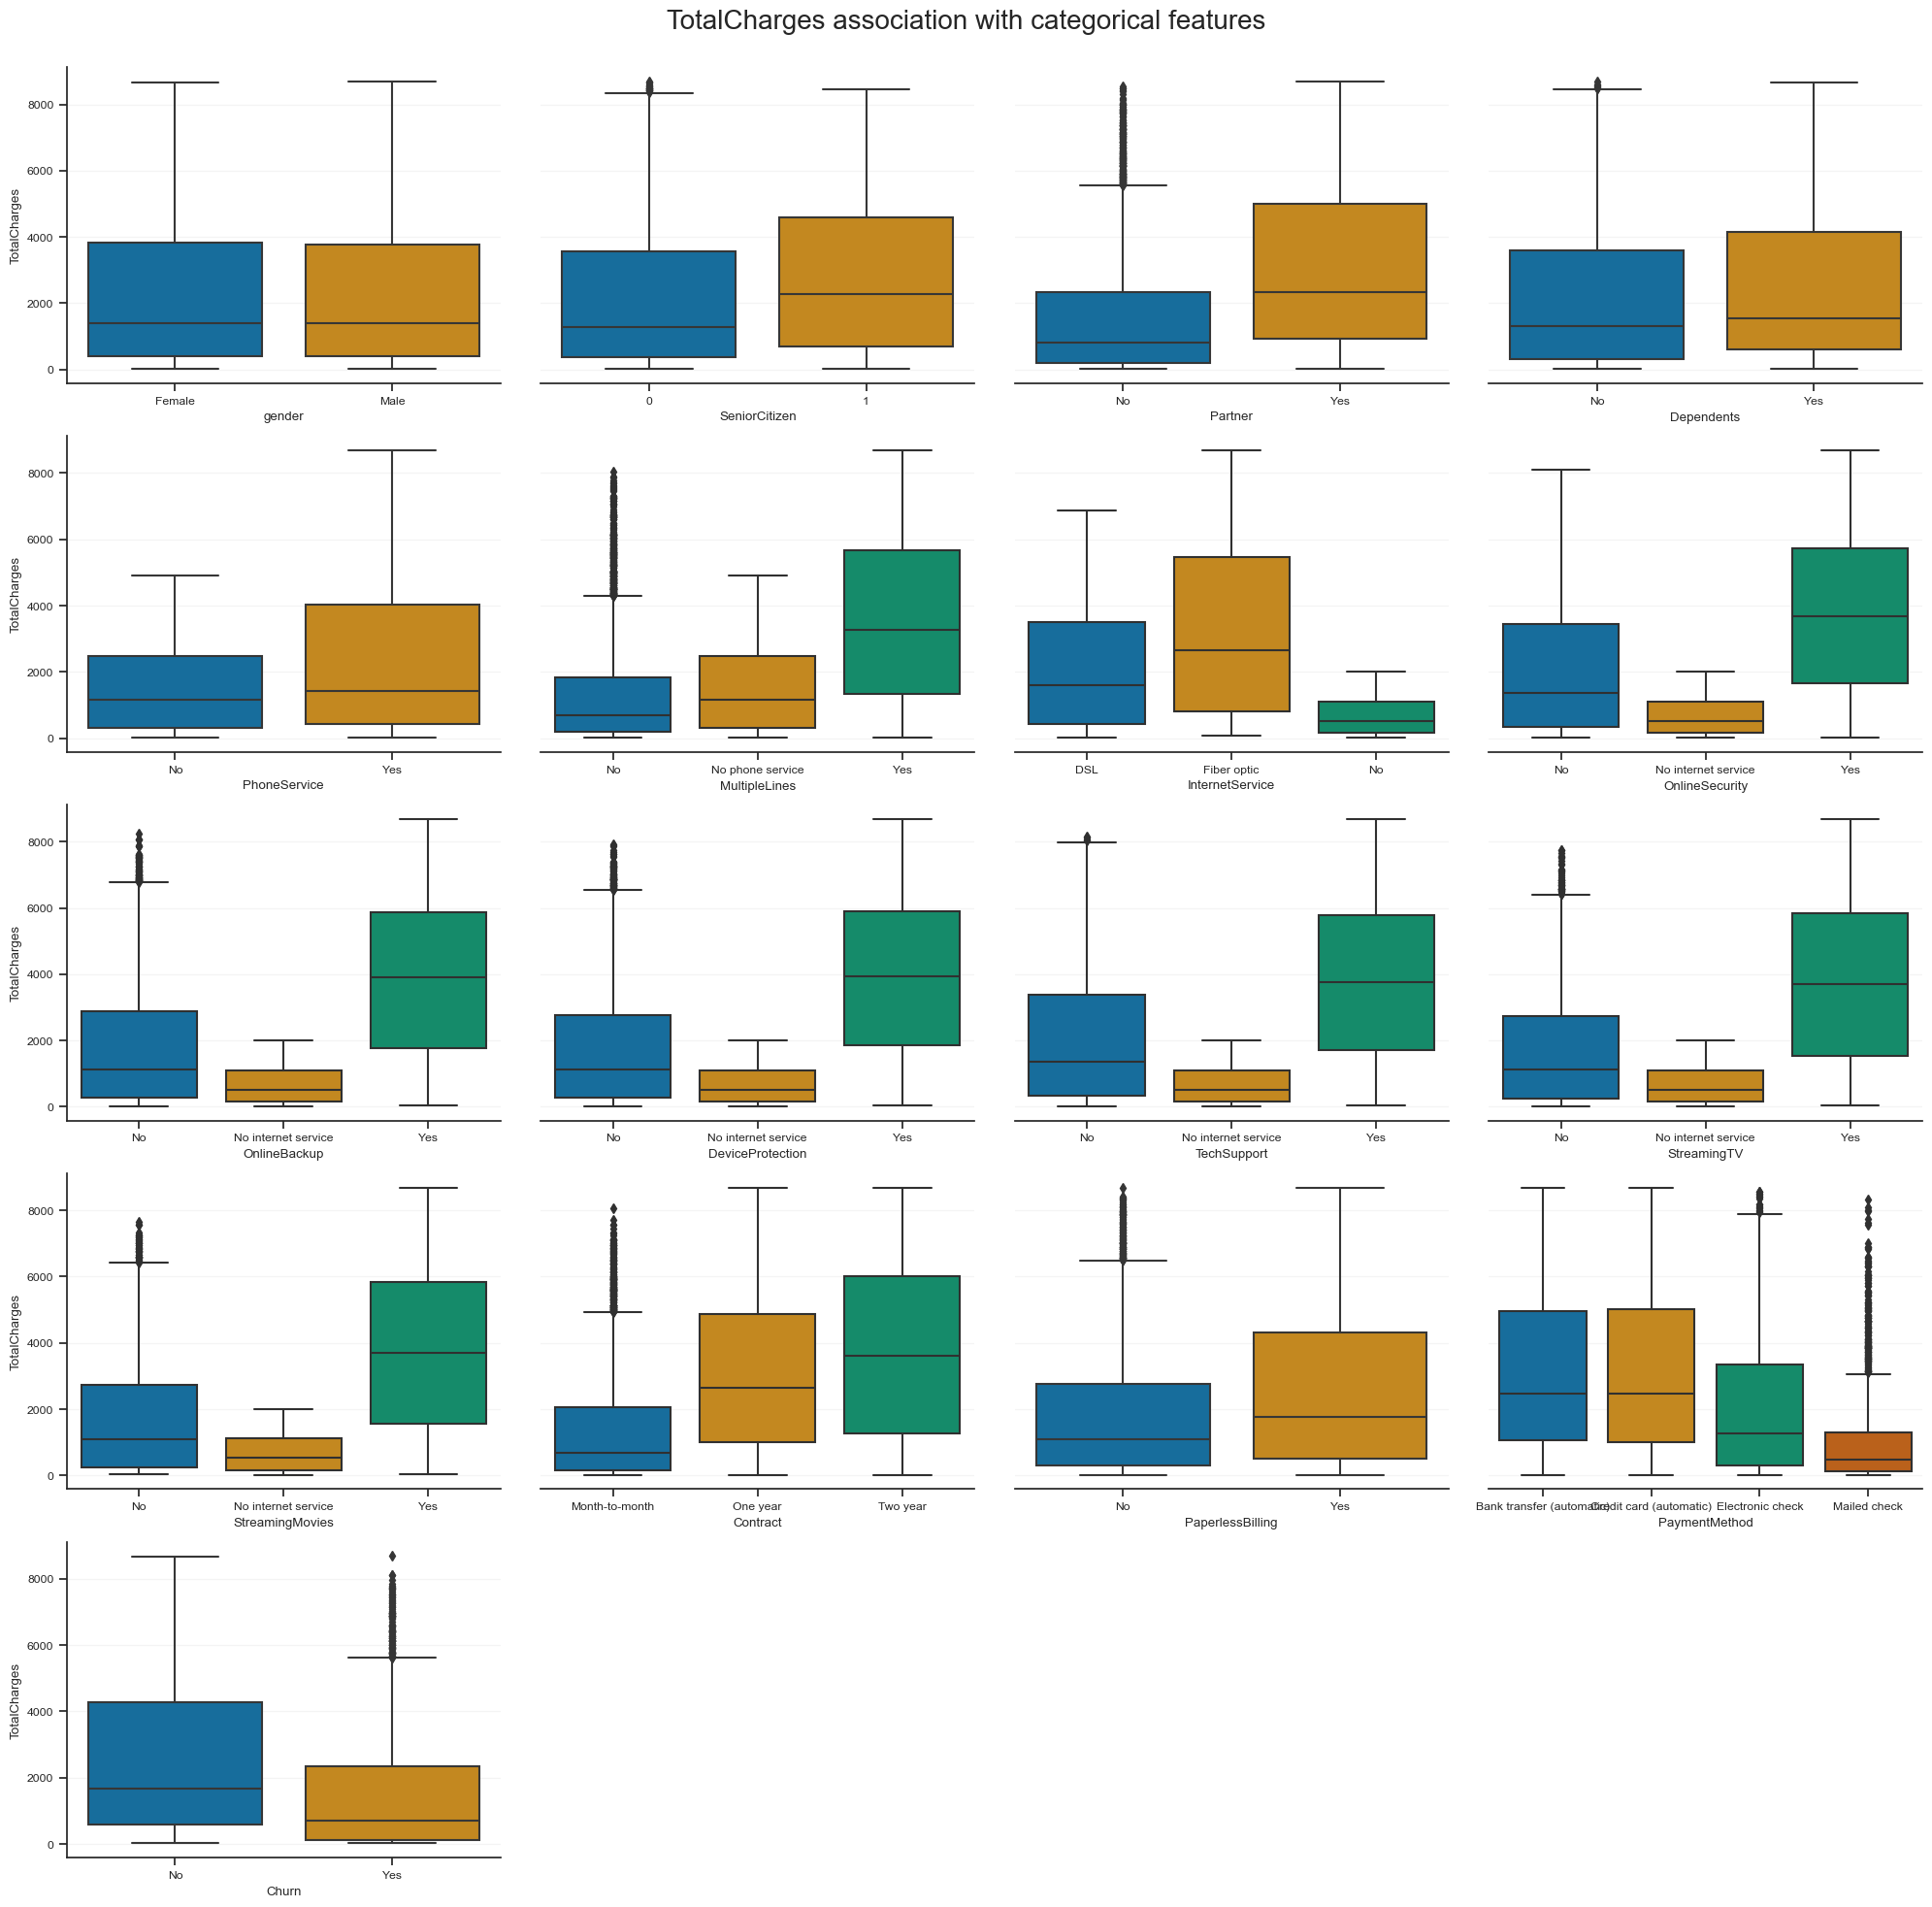

In [14]:
# Visualizing numerical features distribution by categories
ncols = 4
nrows = round((len(cat_cols) + 1) / ncols + .5)
for num_col in num_cols:
    fig, axes = plt.subplots(figsize=(20, 20), ncols=ncols, nrows=nrows, sharey="row")
    axes = axes.flatten()
    for i, cat_col in enumerate(cat_cols):
        sns.boxplot(data=df, y=num_col, x=cat_col, ax=axes[i])
        axes[i].set_ylabel("")
        axes[i].spines["top"].set_visible(False)
        axes[i].spines["right"].set_visible(False)
        if i % ncols == 0:
            axes[i].set_ylabel(num_col)
        else:
            axes[i].spines["left"].set_visible(False)
            axes[i].tick_params(axis="y", which="both", left=False)
    sns.boxplot(data=df, y=num_col, x="Churn", ax=axes[i+1])
    axes[i+1].spines["top"].set_visible(False)
    axes[i+1].spines["right"].set_visible(False)
    for ax in axes[len(cat_cols)+1:]:
        ax.set_axis_off()
    fig.suptitle(f"{num_col} association with categorical features", size=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.95)

In [15]:
# Applying OneHotEncoder transformation on categorical features
transformer = ColumnTransformer(
    transformers=[("onehot", OneHotEncoder(drop="if_binary", sparse_output=False), cat_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False
)

transformer.set_output(transform="pandas")
df_encoded = transformer.fit_transform(df)
df_encoded.head()

,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,...,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,customerID,tenure,MonthlyCharges,TotalCharges,Churn
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,7590-VHVEG,1,29.85,29.85,No
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,5575-GNVDE,34,56.95,1889.50,No
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,3668-QPYBK,2,53.85,108.15,Yes
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,7795-CFOCW,45,42.30,1840.75,No
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,9237-HQITU,2,70.70,151.65,Yes


#### 3.1.2.1 ANOVA and T-test

In [16]:
# Creating empty dataframe with numerical features as index and categorical features as columns
df_association = pd.DataFrame(index=num_cols,
                        columns=(list(cat_cols) + ["Churn"]))

In [17]:
df_association

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
tenure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalCharges,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# The empty dataframe will be filled with p-value of ANOVA for features with 3 categories or more and 
# T-test for features with 2 categories

In [19]:
for num_col in df_association.index:
    for cat_col in df_association.columns:
        cats2compare = []
        num_cats = len(df[cat_col].unique())
        if num_cats > 2:
            for cat in df[cat_col].unique():
                cats2compare.append(df[df[cat_col] == cat][num_col])
            _, p = f_oneway(*cats2compare)
            df_association.loc[num_col, cat_col] = p
        else:
            cat1, cat2 = df[cat_col].unique()
            _, p = ttest_ind(df[df[cat_col] == cat1][num_col],
                             df[df[cat_col] == cat2][num_col])
            df_association.loc[num_col, cat_col] = p

In [20]:
# Visualizing association: red (high p-value) means low association
df_association.apply(pd.to_numeric).T.style.background_gradient(cmap="Reds")

,tenure,MonthlyCharges,TotalCharges
gender,0.657665,0.247950,0.996800
SeniorCitizen,0.188504,0.000000,0.000000
Partner,0.000000,0.000000,0.000000
Dependents,0.000000,0.000000,0.000000
PhoneService,0.508957,0.000000,0.000000
MultipleLines,0.000000,0.000000,0.000000
InternetService,0.007053,0.000000,0.000000
OnlineSecurity,0.000000,0.000000,0.000000
OnlineBackup,0.000000,0.000000,0.000000
DeviceProtection,0.000000,0.000000,0.000000
